In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from DeepEEG.input_preparation import get_labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [3]:
# Define a function to load data from multiple files
def load_activity_data(activity, file_prefix, num_files):
    data_list = []
    for i in range(1, num_files + 1):
        file_path = f"Data/{activity}/{file_prefix} {i}cleaned.csv"
        data = np.genfromtxt(file_path, delimiter=',')
        data_list.append(data)
    return np.concatenate(data_list, axis=0)

In [5]:
# Load data for each activity
reading_data = load_activity_data("Reading", "r", 6)
speaking_data = load_activity_data("Speaking", "s", 4)
watching_data = load_activity_data("Watching", "w", 6)

reading_data.shape

(59192, 5)

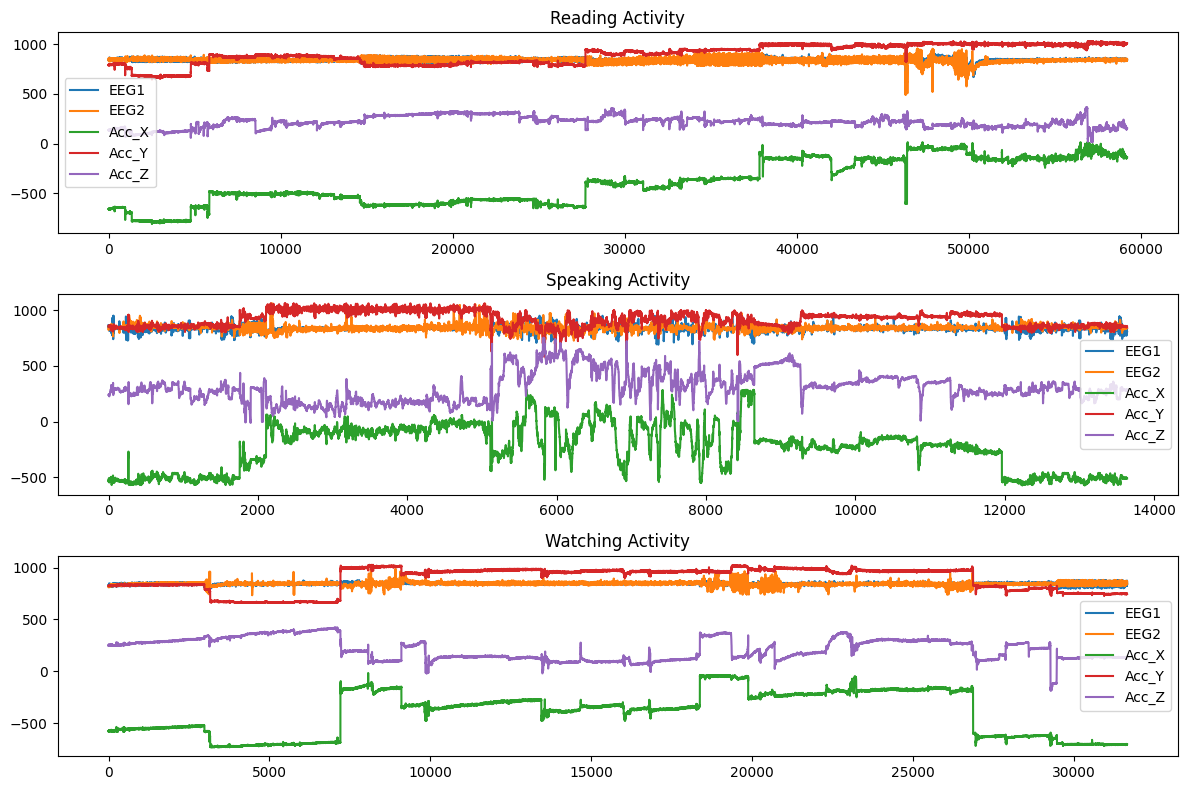

In [8]:
# Plotting all dimensions for each activity
plt.figure(figsize=(12, 8))

# Plotting Reading data
plt.subplot(3, 1, 1)
plt.plot(reading_data[:, 0], label='EEG1')
plt.plot(reading_data[:, 1], label='EEG2')
plt.plot(reading_data[:, 2], label='Acc_X')
plt.plot(reading_data[:, 3], label='Acc_Y')
plt.plot(reading_data[:, 4], label='Acc_Z')
plt.title('Reading Activity')
plt.legend()

# Plotting Speaking data
plt.subplot(3, 1, 2)
plt.plot(speaking_data[:, 0], label='EEG1')
plt.plot(speaking_data[:, 1], label='EEG2')
plt.plot(speaking_data[:, 2], label='Acc_X')
plt.plot(speaking_data[:, 3], label='Acc_Y')
plt.plot(speaking_data[:, 4], label='Acc_Z')
plt.title('Speaking Activity')
plt.legend()

# Plotting Watching data
plt.subplot(3, 1, 3)
plt.plot(watching_data[:, 0], label='EEG1')
plt.plot(watching_data[:, 1], label='EEG2')
plt.plot(watching_data[:, 2], label='Acc_X')
plt.plot(watching_data[:, 3], label='Acc_Y')
plt.plot(watching_data[:, 4], label='Acc_Z')
plt.title('Watching Activity')
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


In [10]:
# Create labels for each activity
reading_labels = np.full((reading_data.shape[0],), 
                         fill_value=0)  # 0 represents reading
speaking_labels = np.full((speaking_data.shape[0],),
                           fill_value=1)  # 1 represents speaking
watching_labels = np.full((watching_data.shape[0],),
                           fill_value=2)  # 2 represents watching

In [11]:
X = np.concatenate((reading_data, speaking_data, watching_data), axis=0)
y = np.concatenate((reading_labels, speaking_labels, watching_labels), axis=0)

In [12]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, 
test_size=0.2, random_state=42)

In [14]:

# Reshape data for LSTM (assuming data is 1D, modify as needed if your data has more dimensions)
X_train_reshaped = X_train.reshape(X_train.shape[0], 
                                   X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0],
                                  X_test.shape[1], 1)

In [17]:
import os

# Function to create an LSTM model
def create_lstm_model(input_shape,X_train_reshaped, X_test_reshaped, y_train, y_test):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        tf.keras.layers.LSTM(units=32),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')  
    ])
    model.compile(optimizer=Adam(0.001), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train_reshaped,
                     y_train, epochs=20, batch_size=32, 
validation_data=(X_test_reshaped, y_test))
    return model

# Function to save the model
def save_model(model, filename):
    model.save(filename)
    print(f"Model saved as {filename}")

# Function to load the model
def load_model(filename):
    if os.path.exists(filename):
        loaded_model = tf.keras.models.load_model(filename)
        print(f"Model loaded from {filename}")
        return loaded_model
    else:
        print(f"No model found at {filename}")
        return None


In [19]:
# Create the model
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
model = create_lstm_model(input_shape, X_train_reshaped=X_train_reshaped, 
                          X_test_reshaped=X_test_reshaped,
                          y_train=y_train, 
                          y_test=y_test)

# Save the model
save_model(model, 'my_lstm_model.keras')

# Load the model
loaded_model = load_model('my_lstm_model.keras')


Epoch 1/20
2612/2612 [==============================] - 17s 6ms/step - loss: 0.6297 - accuracy: 0.7494 - val_loss: 0.5369 - val_accuracy: 0.8050
Epoch 2/20
2612/2612 [==============================] - 14s 5ms/step - loss: 0.4405 - accuracy: 0.8262 - val_loss: 0.4106 - val_accuracy: 0.8520
Epoch 3/20
2612/2612 [==============================] - 9s 3ms/step - loss: 0.3981 - accuracy: 0.8492 - val_loss: 0.3723 - val_accuracy: 0.8590
Epoch 4/20
2612/2612 [==============================] - 10s 4ms/step - loss: 0.3861 - accuracy: 0.8528 - val_loss: 0.3443 - val_accuracy: 0.8789
Epoch 5/20
2612/2612 [==============================] - 12s 4ms/step - loss: 0.3611 - accuracy: 0.8606 - val_loss: 0.3669 - val_accuracy: 0.8664
Epoch 6/20
2612/2612 [==============================] - 8s 3ms/step - loss: 0.3487 - accuracy: 0.8664 - val_loss: 0.3387 - val_accuracy: 0.8752
Epoch 7/20
2612/2612 [==============================] - 10s 4ms/step - loss: 0.3482 - accuracy: 0.8661 - val_loss: 0.3148 - val_accu